In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import pandas as pd

json_path = '/content/drive/MyDrive/transformer_predictions.json'
df_test = pd.read_json(json_path, lines=True)

# 查看数据结构
print(df_test.info())
print(df_test.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10200 entries, 0 to 10199
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   review_id         10200 non-null  object
 1   true_label        10200 non-null  int64 
 2   transformer_pred  10200 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 239.2+ KB
None
                              review_id  true_label  transformer_pred
0  cb35f6d1-a297-4cf6-99bc-19d1c3e05116           0                 0
1  426411d0-768b-415f-9eb8-f0461da6ae01           1                 1
2  3fe3cf0b-d4e8-44d1-be91-9504b92dc871           0                 0
3  48a27a5f-eb34-42d3-8763-7e2e5de525e4           2                 2
4  dffc3d82-dc73-4556-b486-fb0539663767           1                 1


In [ ]:
df_reviews = pd.read_csv('/content/drive/MyDrive/final_balanced_reviews.csv')

print(df_reviews.info())
print(df_reviews.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102000 entries, 0 to 101999
Data columns (total 6 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   review_id  102000 non-null  object
 1   title      102000 non-null  object
 2   text       102000 non-null  object
 3   sentiment  102000 non-null  object
 4   input      102000 non-null  object
 5   label      102000 non-null  int64 
dtypes: int64(1), object(5)
memory usage: 4.7+ MB
None
                              review_id                             title  \
0  fe70f3d2-743b-41d9-8c11-a1478683920b    Cleaning chemical smell yuck!!   
1  0c12eeda-f14b-4cbb-be34-9fb53e65c482              Major disappointment   
2  c8ad64e5-1df4-4130-963f-87e7e1306614                 Like it but broke   
3  d3baee99-5cec-4402-8d8e-f7b1f22509ab  Something is off with the smell.   
4  863b859c-0d02-4355-b2e2-fdac0f9e0b56           All that pain for what?   

                                                text

In [ ]:
df_merged = pd.merge(df_test, df_reviews, on='review_id', how='left')
df_final = df_merged[['review_id', 'text','title', 'transformer_pred']]
df_final = df_final[df_final['transformer_pred'] == 0]
df = df_final

In [ ]:
!pip install kneed

In [ ]:
df_final.to_csv("/content/drive/MyDrive/5153_negative_reviews.csv")

## Only text TF-IDF + K-means


📈 Calculating inertia & silhouette for different K values...
K=2, Inertia=2906.17, Silhouette=0.0055
K=3, Inertia=2892.45, Silhouette=0.0066
K=4, Inertia=2881.78, Silhouette=0.0065
K=5, Inertia=2878.12, Silhouette=0.0068
K=6, Inertia=2862.05, Silhouette=0.0084
K=7, Inertia=2855.23, Silhouette=0.0089
K=8, Inertia=2844.34, Silhouette=0.0106
K=9, Inertia=2834.92, Silhouette=0.0114
K=10, Inertia=2826.3, Silhouette=0.0122
K=11, Inertia=2819.71, Silhouette=0.0128
K=12, Inertia=2813.59, Silhouette=0.0132
K=13, Inertia=2810.43, Silhouette=0.0133
K=14, Inertia=2804.67, Silhouette=0.0137


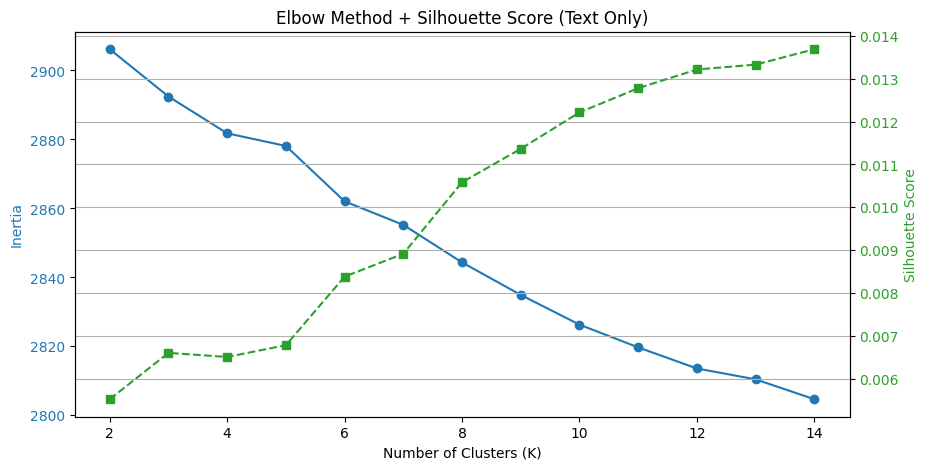


✅ Optimal K from Elbow: 10

📌 每个簇的前 10 个关键词（只用 text）：

Cluster 0: book, br, read, story, books, like, just, characters, author, pages
Cluster 1: product, use, just, bought, buy, got, did, time, don, good
Cluster 2: money, waste, don, time, worth, product, work, total, dont, using
Cluster 3: work, did, does, didn, doesn, bought, don, returned, buy, use
Cluster 4: magazine, articles, issue, ads, subscription, just, cooking, advertising, magazines, tv
Cluster 5: fit, size, small, 34, did, tight, ordered, large, didn, just
Cluster 6: cheap, plastic, product, quality, like, buy, money, returned, looks, worth
Cluster 7: cd, quality, album, poor, sound, songs, good, quot, music, song
Cluster 8: like, just, don, taste, didn, really, looks, smells, look, smell
Cluster 9: br, just, like, 34, good, don, time, use, product, really

📝 每个 cluster 的代表评论：


Cluster 0 Example Review:
No caramel.  All peanuts and not tasty at all....


Cluster 1 Example Review:
No caramel.  All peanuts and not tasty at

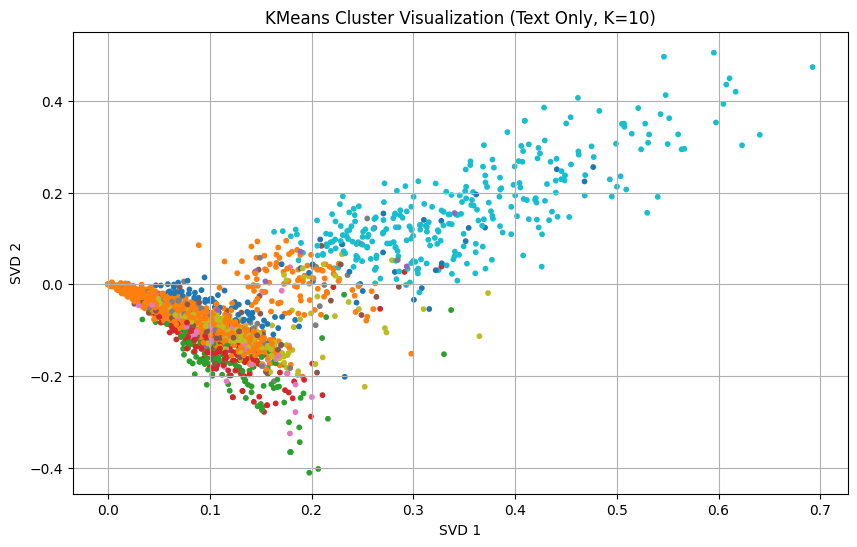


📦 Sampled 50 comments per cluster saved to: text_only_cluster_samples.csv


<ipython-input-11-10111fa878ff>:92: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_df = df.groupby("cluster").apply(lambda x: x.sample(n=min(50, len(x)), random_state=42)).reset_index(drop=True)


In [ ]:
from sklearn.metrics import silhouette_score
import pandas as pd
import glob
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import pairwise_distances_argmin_min
from kneed import KneeLocator

# 1. 加载数据
df = df_final

# 2. 准备字段（只保留 text）
df["text"] = df["text"].fillna("").astype(str)
df = df[df["text"].str.len() > 20].reset_index(drop=True)

# 3. 用 text 做 TF-IDF 向量化
vectorizer = TfidfVectorizer(max_df=0.9, min_df=5, stop_words='english', max_features=5000)
X_text = vectorizer.fit_transform(df["text"])

# 4. Elbow 法 + Silhouette Score 找最佳 K
inertias = []
silhouettes = []
ks = range(2, 15)
print("\n📈 Calculating inertia & silhouette for different K values...")
for k in ks:
    km = KMeans(n_clusters=k, random_state=42)
    labels = km.fit_predict(X_text)
    inertias.append(km.inertia_)
    score = silhouette_score(X_text, labels)
    silhouettes.append(score)
    print(f"K={k}, Inertia={round(km.inertia_, 2)}, Silhouette={round(score, 4)}")

# 双轴图：Inertia + Silhouette
fig, ax1 = plt.subplots(figsize=(10, 5))

color1 = "tab:blue"
ax1.set_xlabel("Number of Clusters (K)")
ax1.set_ylabel("Inertia", color=color1)
ax1.plot(ks, inertias, marker='o', color=color1)
ax1.tick_params(axis="y", labelcolor=color1)

ax2 = ax1.twinx()
color2 = "tab:green"
ax2.set_ylabel("Silhouette Score", color=color2)
ax2.plot(ks, silhouettes, marker='s', linestyle='--', color=color2)
ax2.tick_params(axis="y", labelcolor=color2)

plt.title("Elbow Method + Silhouette Score (Text Only)")
plt.grid(True)
plt.show()

# 拐点检测（仍用 Inertia 找 best_k）
from kneed import KneeLocator
kl = KneeLocator(ks, inertias, curve="convex", direction="decreasing")
best_k = kl.elbow
print(f"\n✅ Optimal K from Elbow: {best_k}")

# 5. 聚类
model = KMeans(n_clusters=best_k, random_state=42)
df["cluster"] = model.fit_predict(X_text)

# 6. 每个 cluster 的关键词（取前 10 个）
terms = vectorizer.get_feature_names_out()
order_centroids = model.cluster_centers_.argsort()[:, ::-1]

print("\n📌 每个簇的前 10 个关键词（只用 text）：\n")
for i in range(best_k):
    top_words = [terms[ind] for ind in order_centroids[i, :10]]
    print(f"Cluster {i}: {', '.join(top_words)}")

# 7. 每个 cluster 的代表评论（最靠近中心）
print("\n📝 每个 cluster 的代表评论：\n")
closest, _ = pairwise_distances_argmin_min(model.cluster_centers_, X_text)
for i, idx in enumerate(closest):
    print(f"\nCluster {i} Example Review:\n{df.iloc[idx]['text'][:400]}...\n")

# 8. 可视化降维
svd = TruncatedSVD(n_components=2, random_state=42)
X_svd = svd.fit_transform(X_text)

plt.figure(figsize=(10, 6))
plt.scatter(X_svd[:, 0], X_svd[:, 1], c=df["cluster"], cmap="tab10", s=10)
plt.title(f"KMeans Cluster Visualization (Text Only, K={best_k})")
plt.xlabel("SVD 1")
plt.ylabel("SVD 2")
plt.grid(True)
plt.show()

# 9. 每个 cluster 抽样 50 条文本（可选）
sampled_df = df.groupby("cluster").apply(lambda x: x.sample(n=min(50, len(x)), random_state=42)).reset_index(drop=True)
sampled_df.to_csv("text_only_cluster_samples.csv", index=False)
print("\n📦 Sampled 50 comments per cluster saved to: text_only_cluster_samples.csv")



## text和title分开encoding, TF-IDF + K-means


📈 Calculating inertia & silhouette for different K values...
K=2, Inertia=5494.92, Silhouette=0.0085
K=3, Inertia=5444.93, Silhouette=0.0084
K=4, Inertia=5428.58, Silhouette=0.0137
K=5, Inertia=5349.85, Silhouette=0.0195
K=6, Inertia=5493.15, Silhouette=0.0148
K=7, Inertia=5444.57, Silhouette=0.0177
K=8, Inertia=5335.72, Silhouette=0.0208
K=9, Inertia=5294.26, Silhouette=0.0223
K=10, Inertia=5249.82, Silhouette=0.0245
K=11, Inertia=5233.85, Silhouette=0.0258
K=12, Inertia=5229.43, Silhouette=0.026
K=13, Inertia=5203.94, Silhouette=0.0262
K=14, Inertia=5193.84, Silhouette=0.0268


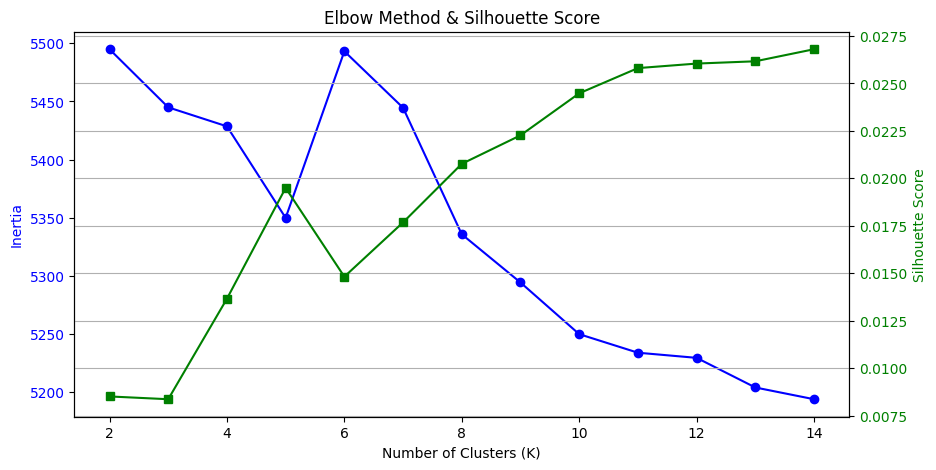


✅ Optimal K detected by Elbow: 5

📌 每个簇的前 10 个关键词（仅基于正文）

Cluster 0: disappointed, product, br, like, gift, really, 34, time, don, lot
Cluster 1: like, work, just, don, product, did, didn, use, money, good
Cluster 2: money, waste, don, product, time, br, worth, using, use, like
Cluster 3: br, like, just, quality, book, don, good, time, 34, use
Cluster 4: buy, br, use, bought, money, just, junk, does, card, really

📝 每个 cluster 的代表评论：


Cluster 0 Example Review:
More of the usual anti freedom propaganda | Leftist anti freedom propaganda...


Cluster 1 Example Review:
More of the usual anti freedom propaganda | Leftist anti freedom propaganda...


Cluster 2 Example Review:
A waste of money. | No caramel.  All peanuts and not tasty at all....


Cluster 3 Example Review:
More of the usual anti freedom propaganda | Leftist anti freedom propaganda...


Cluster 4 Example Review:
More of the usual anti freedom propaganda | Leftist anti freedom propaganda...



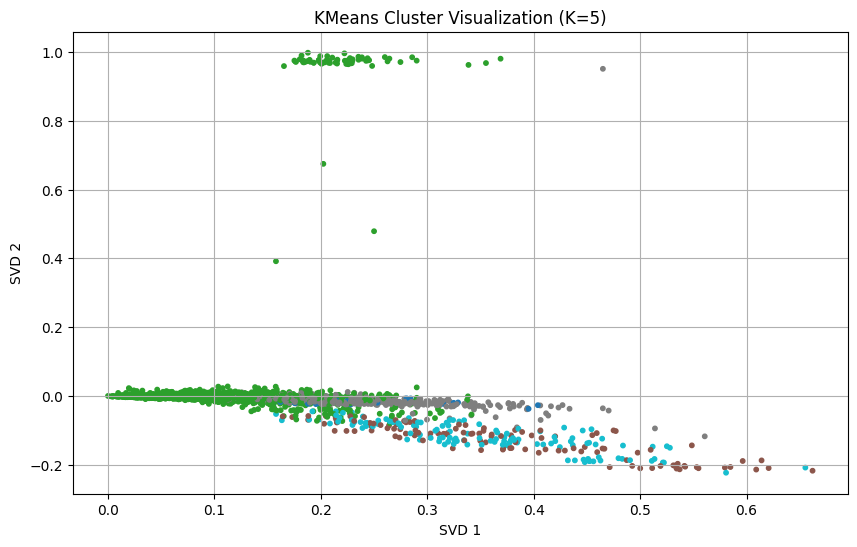

In [ ]:
import pandas as pd
import glob
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import pairwise_distances_argmin_min, silhouette_score  # ✅ 加上 silhouette_score
from scipy.sparse import hstack
from kneed import KneeLocator

df = df_final

df["title"] = df["title"].fillna("").astype(str)
df["text"] = df["text"].fillna("").astype(str)
df = df[df["text"].str.len() > 20].reset_index(drop=True)

# 2. 分开向量化 title 和 text（保留高频重要词）
vectorizer_title = TfidfVectorizer(max_df=0.8, min_df=3, stop_words='english', max_features=2000)
vectorizer_text = TfidfVectorizer(max_df=0.9, min_df=5, stop_words='english', max_features=5000)

X_title = vectorizer_title.fit_transform(df["title"])
X_text = vectorizer_text.fit_transform(df["text"])

# 3. 合并 title 和 text 的特征
X_combined = hstack([X_title, X_text])

# 4. Elbow 法找最佳 K
inertias = []
silhouette_scores = []  # ✅ 存储每个 k 的轮廓系数
ks = range(2, 15)
print("\n📈 Calculating inertia & silhouette for different K values...")
for k in ks:
    km = KMeans(n_clusters=k, random_state=42)
    labels = km.fit_predict(X_combined)
    inertia = km.inertia_
    inertias.append(inertia)

    # ✅ 计算 silhouette（样本数 >= k+1，否则可能报错）
    if len(df) > k:
        score = silhouette_score(X_combined, labels)
        silhouette_scores.append(score)
        print(f"K={k}, Inertia={round(inertia, 2)}, Silhouette={round(score, 4)}")
    else:
        silhouette_scores.append(None)
        print(f"K={k}, Inertia={round(inertia, 2)}, Silhouette=N/A")

# 画 Elbow 图 + Silhouette Score 图
fig, ax1 = plt.subplots(figsize=(10, 5))
ax1.plot(ks, inertias, marker='o', color='blue', label='Inertia')
ax1.set_xlabel("Number of Clusters (K)")
ax1.set_ylabel("Inertia", color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_title("Elbow Method & Silhouette Score")

ax2 = ax1.twinx()
ax2.plot(ks, silhouette_scores, marker='s', color='green', label='Silhouette Score')
ax2.set_ylabel("Silhouette Score", color='green')
ax2.tick_params(axis='y', labelcolor='green')

plt.grid(True)
plt.show()

# 自动识别拐点
kl = KneeLocator(ks, inertias, curve="convex", direction="decreasing")
best_k = kl.elbow
print(f"\n✅ Optimal K detected by Elbow: {best_k}")

# 5. 用最佳 K 聚类
model = KMeans(n_clusters=best_k, random_state=42)
df["cluster"] = model.fit_predict(X_combined)

# 6. 输出每个 cluster 的前 10 个关键词（仅 text 部分）
terms = vectorizer_text.get_feature_names_out()
order_centroids = model.cluster_centers_[:, X_title.shape[1]:].argsort()[:, ::-1]

print("\n📌 每个簇的前 10 个关键词（仅基于正文）\n")
for i in range(best_k):
    top_words = [terms[ind] for ind in order_centroids[i, :10]]
    print(f"Cluster {i}: {', '.join(top_words)}")

# 7. 每个 cluster 的代表评论（最靠近中心）
print("\n📝 每个 cluster 的代表评论：\n")
closest, _ = pairwise_distances_argmin_min(model.cluster_centers_, X_combined)
for i, idx in enumerate(closest):
    print(f"\nCluster {i} Example Review:\n{df.iloc[idx]['title']} | {df.iloc[idx]['text'][:400]}...\n")

# 8. 可视化：TruncatedSVD 降到 2 维
svd = TruncatedSVD(n_components=2, random_state=42)
X_2d = svd.fit_transform(X_combined)

plt.figure(figsize=(10, 6))
plt.scatter(X_2d[:, 0], X_2d[:, 1], c=df["cluster"], cmap="tab10", s=10)
plt.title(f"KMeans Cluster Visualization (K={best_k})")
plt.xlabel("SVD 1")
plt.ylabel("SVD 2")
plt.grid(True)
plt.show()

## title+text combined TF-IDF + K-means


📈 Calculating Inertia & Silhouette Scores for K from 2 to 14...
K = 2, Inertia = 3026.79, Silhouette = 0.0044
K = 3, Inertia = 3015.86, Silhouette = 0.0053
K = 4, Inertia = 2997.96, Silhouette = 0.0075
K = 5, Inertia = 2988.46, Silhouette = 0.0086
K = 6, Inertia = 2975.37, Silhouette = 0.0096
K = 7, Inertia = 2964.22, Silhouette = 0.0105
K = 8, Inertia = 2959.59, Silhouette = 0.0105
K = 9, Inertia = 2944.92, Silhouette = 0.0123
K = 10, Inertia = 2933.5, Silhouette = 0.0132
K = 11, Inertia = 2920.06, Silhouette = 0.0146
K = 12, Inertia = 2919.84, Silhouette = 0.0145
K = 13, Inertia = 2908.91, Silhouette = 0.0156
K = 14, Inertia = 2908.96, Silhouette = 0.0154


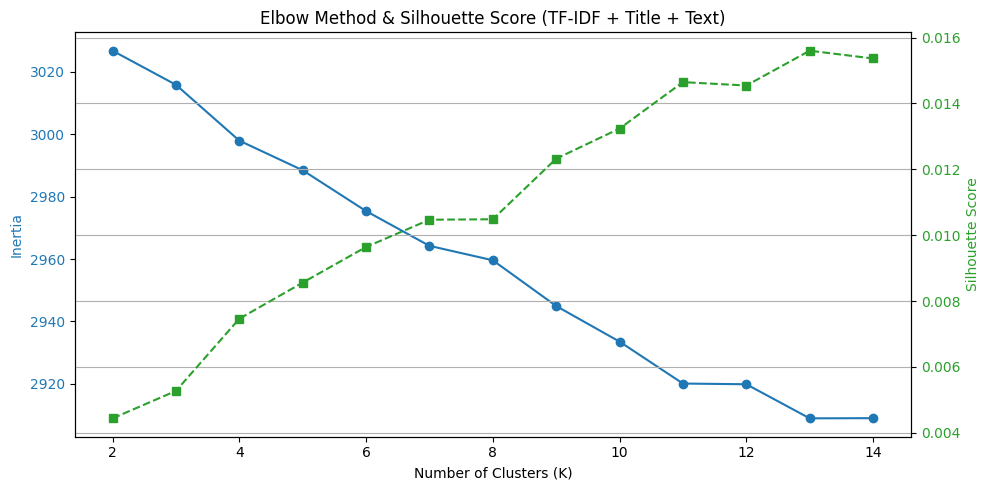


✅ Optimal K (by Elbow): 13


In [ ]:
import pandas as pd
import glob
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD
from sklearn.metrics import pairwise_distances_argmin_min

# ✅ 如果没装过 kneed，请先安装（只需一次）
!pip install -q kneed

from kneed import KneeLocator

# 1. 合并所有 CSV 并拼接 title + text
df = df_final

df["title"] = df["title"].fillna("").astype(str)
df["text"] = df["text"].fillna("").astype(str)
df["text_combined"] = df["title"] + " " + df["text"]
df = df[df["text_combined"].str.len() > 20].reset_index(drop=True)

# 2. TF-IDF 向量化
vectorizer = TfidfVectorizer(max_df=0.9, min_df=5, stop_words='english')
X = vectorizer.fit_transform(df["text_combined"])

# 3. 自动寻找最优 K（Elbow 法 + Silhouette Score）
inertias = []
silhouettes = []
ks = list(range(2, 15))

print("\n📈 Calculating Inertia & Silhouette Scores for K from 2 to 14...")
for k in ks:
    km = KMeans(n_clusters=k, random_state=42)
    labels = km.fit_predict(X)
    inertia = km.inertia_
    silhouette = silhouette_score(X, labels)
    inertias.append(inertia)
    silhouettes.append(silhouette)
    print(f"K = {k}, Inertia = {round(inertia, 2)}, Silhouette = {round(silhouette, 4)}")

# 画双轴图：Elbow + Silhouette
fig, ax1 = plt.subplots(figsize=(10, 5))

ax1.set_xlabel("Number of Clusters (K)")
ax1.set_ylabel("Inertia", color="tab:blue")
ax1.plot(ks, inertias, marker="o", color="tab:blue", label="Inertia")
ax1.tick_params(axis="y", labelcolor="tab:blue")

ax2 = ax1.twinx()
ax2.set_ylabel("Silhouette Score", color="tab:green")
ax2.plot(ks, silhouettes, marker="s", linestyle="--", color="tab:green", label="Silhouette Score")
ax2.tick_params(axis="y", labelcolor="tab:green")

plt.title("Elbow Method & Silhouette Score (TF-IDF + Title + Text)")
fig.tight_layout()
plt.grid(True)
plt.show()

# ✅ 拐点识别（基于 Inertia）
kl = KneeLocator(ks, inertias, curve="convex", direction="decreasing")
best_k = kl.elbow
print(f"\n✅ Optimal K (by Elbow): {best_k}")


## text+title combined BERT + KMeans

In [ ]:
!pip install -q sentence-transformers

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/99 [00:00<?, ?it/s]

📈 Calculating silhouette scores:
K=2, Silhouette Score=0.024700000882148743
K=3, Silhouette Score=0.027799999341368675
K=4, Silhouette Score=0.02979999966919422
K=5, Silhouette Score=0.02969999983906746
K=6, Silhouette Score=0.02630000002682209
K=7, Silhouette Score=0.03449999913573265
K=8, Silhouette Score=0.034299999475479126
K=9, Silhouette Score=0.03700000047683716
K=10, Silhouette Score=0.03680000081658363
K=11, Silhouette Score=0.03779999911785126
K=12, Silhouette Score=0.03869999945163727
K=13, Silhouette Score=0.03920000046491623
K=14, Silhouette Score=0.037700001150369644


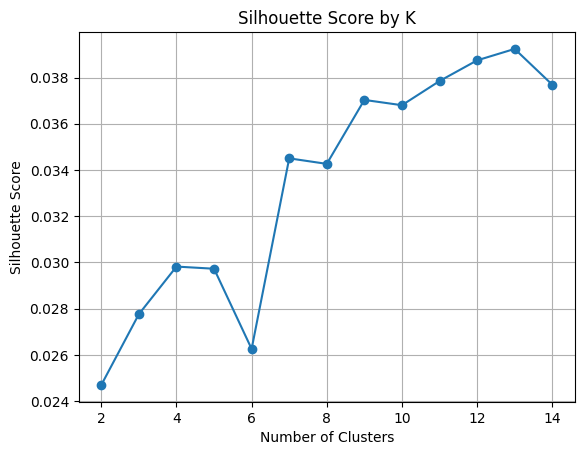


📌 每个簇的代表性评论（title + 前 100 字 text）:

Cluster 0:
Title: Same Old Pseudo Ghost Documentary
Text: *Spoilers*<br /><br />I do believe that the family’s experiences in the home and that the police rep...

Cluster 1:
Title: garbage
Text: not at all good for a person with visual difficulties...

Cluster 2:
Title: Two Stars
Text: eh...

Cluster 3:
Title: Junk
Text: I requested sketches and got these instead. Complete junk, too small and a big disappointment....

Cluster 4:
Title: Not soft or right sizing
Text: Not a nice fabric and way smaller then the size chart...



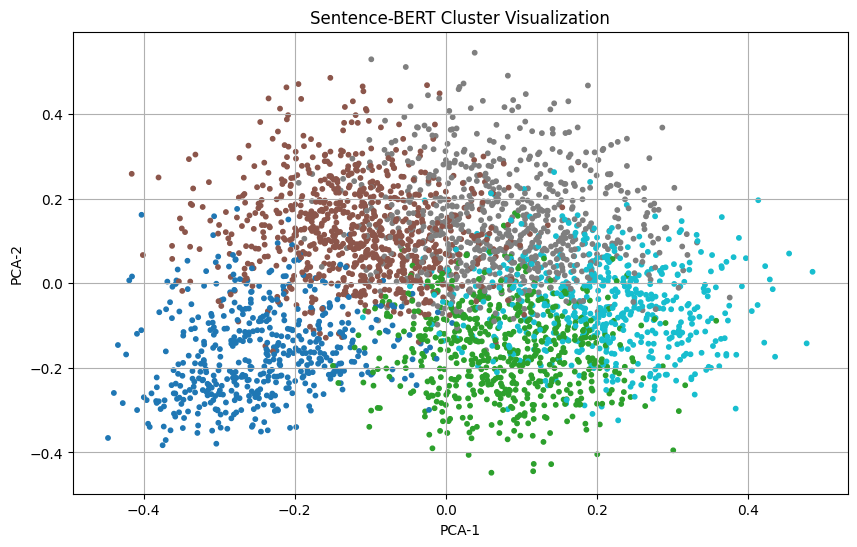

In [ ]:
import pandas as pd
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# 1. 读取数据
df = df_final
df['title'] = df['title'].fillna('')
df['text'] = df['text'].fillna('')
df['combined'] = df['title'] + ' ' + df['text']

# 2. 生成句向量（MiniLM 非常快且效果好）
model = SentenceTransformer('all-MiniLM-L6-v2')
embeddings = model.encode(df['combined'].tolist(), show_progress_bar=True)

# 3. KMeans 聚类 + silhouette score 评估
k_range = range(2, 15)
scores = []
print("📈 Calculating silhouette scores:")
for k in k_range:
    km = KMeans(n_clusters=k, random_state=42)
    labels = km.fit_predict(embeddings)
    score = silhouette_score(embeddings, labels)
    scores.append(score)
    print(f"K={k}, Silhouette Score={round(score, 4)}")

# 4. 可视化 silhouette 分数
plt.plot(k_range, scores, marker='o')
plt.title("Silhouette Score by K")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.show()

# 5. 聚类并保存结果（你可以选最佳 K，比如 k=5）
best_k = 5
model_km = KMeans(n_clusters=best_k, random_state=42)
df['cluster'] = model_km.fit_predict(embeddings)

# 6. 每簇输出几条示例
print("\n📌 每个簇的代表性评论（title + 前 100 字 text）:\n")
for k in range(best_k):
    sample = df[df['cluster'] == k].iloc[0]
    print(f"Cluster {k}:")
    print(f"Title: {sample['title']}")
    print(f"Text: {sample['text'][:100]}...\n")

# 7. 降维可视化（用 PCA）
pca = PCA(n_components=2)
X_2d = pca.fit_transform(embeddings)
plt.figure(figsize=(10,6))
plt.scatter(X_2d[:, 0], X_2d[:, 1], c=df["cluster"], cmap="tab10", s=10)
plt.title("Sentence-BERT Cluster Visualization")
plt.xlabel("PCA-1")
plt.ylabel("PCA-2")
plt.grid(True)
plt.show()

Batches:   0%|          | 0/99 [00:00<?, ?it/s]

📈 Calculating silhouette scores:
K=2, Silhouette Score=0.02710000053048134
K=3, Silhouette Score=0.028200000524520874
K=4, Silhouette Score=0.03280000016093254
K=5, Silhouette Score=0.033799998462200165
K=6, Silhouette Score=0.035999998450279236
K=7, Silhouette Score=0.03269999846816063
K=8, Silhouette Score=0.03819999843835831
K=9, Silhouette Score=0.03920000046491623
K=10, Silhouette Score=0.037300001829862595
K=11, Silhouette Score=0.03629999980330467
K=12, Silhouette Score=0.03739999979734421
K=13, Silhouette Score=0.037700001150369644
K=14, Silhouette Score=0.03750000149011612


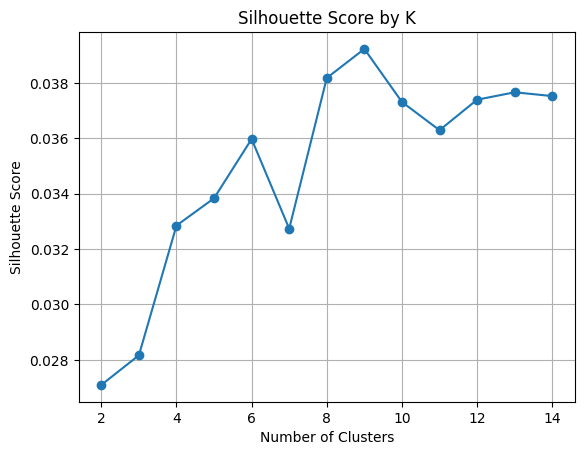


📌 每个簇的代表性评论（title + 前 100 字 text）:

Cluster 0:
Title: These might work great in a spa
Text: These might work great in a spa, but don't seem to do much of anything in my above ground pool...

Cluster 1:
Title: Junk
Text: I requested sketches and got these instead. Complete junk, too small and a big disappointment....

Cluster 2:
Title: Two Stars
Text: eh...

Cluster 3:
Title: Not soft or right sizing
Text: Not a nice fabric and way smaller then the size chart...

Cluster 4:
Title: Same Old Pseudo Ghost Documentary
Text: *Spoilers*<br /><br />I do believe that the family’s experiences in the home and that the police rep...



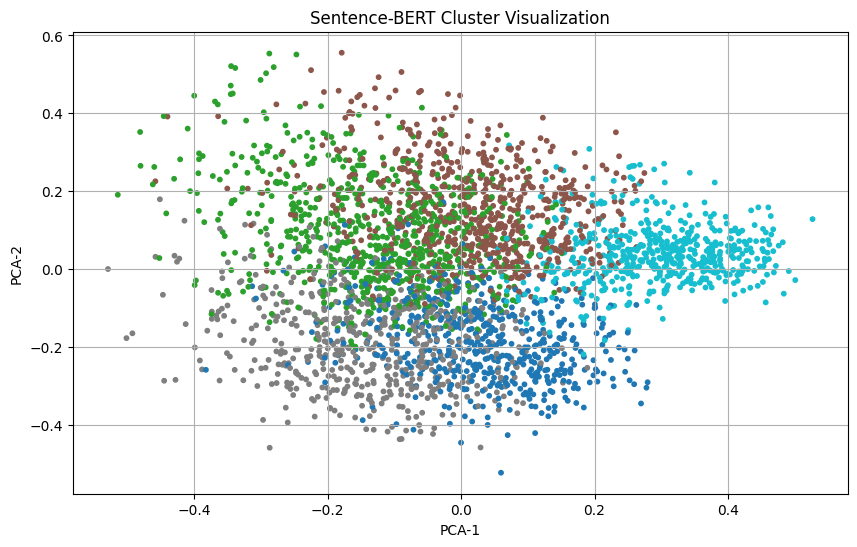

In [ ]:
import pandas as pd
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# 1. 读取数据
df = df_final
df['title'] = df['title'].fillna('')
df['text'] = df['text'].fillna('')
df['combined'] = df['title'] + ' ' + df['text']

# 2. 生成句向量（MiniLM 非常快且效果好）
model = SentenceTransformer('all-mpnet-base-v2')
embeddings = model.encode(df['combined'].tolist(), show_progress_bar=True)

# 3. KMeans 聚类 + silhouette score 评估
k_range = range(2, 15)
scores = []
print("📈 Calculating silhouette scores:")
for k in k_range:
    km = KMeans(n_clusters=k, random_state=42)
    labels = km.fit_predict(embeddings)
    score = silhouette_score(embeddings, labels)
    scores.append(score)
    print(f"K={k}, Silhouette Score={round(score, 4)}")

# 4. 可视化 silhouette 分数
plt.plot(k_range, scores, marker='o')
plt.title("Silhouette Score by K")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.grid(True)
plt.show()

# 5. 聚类并保存结果（你可以选最佳 K，比如 k=5）
best_k = 5
model_km = KMeans(n_clusters=best_k, random_state=42)
df['cluster'] = model_km.fit_predict(embeddings)

# 6. 每簇输出几条示例
print("\n📌 每个簇的代表性评论（title + 前 100 字 text）:\n")
for k in range(best_k):
    sample = df[df['cluster'] == k].iloc[0]
    print(f"Cluster {k}:")
    print(f"Title: {sample['title']}")
    print(f"Text: {sample['text'][:100]}...\n")

# 7. 降维可视化（用 PCA）
pca = PCA(n_components=2)
X_2d = pca.fit_transform(embeddings)
plt.figure(figsize=(10,6))
plt.scatter(X_2d[:, 0], X_2d[:, 1], c=df["cluster"], cmap="tab10", s=10)
plt.title("Sentence-BERT Cluster Visualization")
plt.xlabel("PCA-1")
plt.ylabel("PCA-2")
plt.grid(True)
plt.show()

## BerTopic聚类分析

In [ ]:
# 安装依赖（第一次运行时执行）
!pip install bertopic
!pip install umap-learn

# Step 1: 导入库
import pandas as pd
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer

# Step 2: 读取数据并合并文本
df = pd.read_csv("/content/drive/MyDrive/5153_negative_reviews.csv")
df["title"] = df["title"].fillna("")
df["text"] = df["text"].fillna("")
df["combined"] = df["title"] + " " + df["text"]

# Step 3: 嵌入向量（使用强模型 mpnet）
embedding_model = SentenceTransformer("all-mpnet-base-v2")
embeddings = embedding_model.encode(df["combined"], show_progress_bar=True)

# Step 4: 原始 BERTopic 聚类
topic_model = BERTopic(embedding_model=embedding_model, verbose=True)
topics, probs = topic_model.fit_transform(df["combined"], embeddings)

# Step 5: 精简主题数量（保留前 25 个大主题）
topic_model = topic_model.reduce_topics(df["combined"], nr_topics=25)
topics_reduced, probs_reduced = topic_model.transform(df["combined"])

# Step 6: 添加回原始数据
df["topic"] = topics_reduced
df["topic_prob"] = probs_reduced
df.to_csv("bertopic_labeled_reviews_reduced.csv", index=False)

# Step 7: 显示主题信息（出现最多的主题）
print("📌 Top 10 Topics Summary:")
topic_info = topic_model.get_topic_info()
print(topic_info.head(10))

# Step 8: 查看 Topic 0 的关键词
print("\n🔍 示例：Topic 0 的关键词")
print(topic_model.get_topic(0))

# Step 9: 每个主题的一条代表评论（概率最高）
print("\n📝 每个主题的代表评论：\n")
for topic_num in topic_info["Topic"].tolist()[:10]:
    if topic_num == -1:
        continue
    top_doc_idx = df[df["topic"] == topic_num]["topic_prob"].idxmax()
    print(f"Topic {topic_num}: {topic_model.get_topic(topic_num)[:5]}")
    print(f"  → {df.loc[top_doc_idx, 'combined'][:150]}...\n")

# Step 10: 可视化交互图（建议在 Colab 中打开）
topic_model.visualize_topics()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.6/150.6 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 47.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 24.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 38.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 108.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstal

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.4k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/99 [00:00<?, ?it/s]

2025-04-22 09:04:38,805 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-04-22 09:05:04,333 - BERTopic - Dimensionality - Completed ✓
2025-04-22 09:05:04,335 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-04-22 09:05:04,448 - BERTopic - Cluster - Completed ✓
2025-04-22 09:05:04,455 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-04-22 09:05:04,657 - BERTopic - Representation - Completed ✓
2025-04-22 09:05:04,887 - BERTopic - Topic reduction - Reducing number of topics
2025-04-22 09:05:04,898 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-04-22 09:05:05,054 - BERTopic - Representation - Completed ✓
2025-04-22 09:05:05,056 - BERTopic - Topic reduction - Reduced number of topics from 58 to 25


Batches:   0%|          | 0/99 [00:00<?, ?it/s]

2025-04-22 09:05:21,106 - BERTopic - Dimensionality - Reducing dimensionality of input embeddings.
2025-04-22 09:05:21,127 - BERTopic - Dimensionality - Completed ✓
2025-04-22 09:05:21,129 - BERTopic - Clustering - Approximating new points with `hdbscan_model`
2025-04-22 09:05:21,264 - BERTopic - Cluster - Completed ✓


📌 Top 10 Topics Summary:
   Topic  Count                    Name  \
0     -1    702        -1_the_it_and_to   
1      0    317        0_book_the_of_br   
2      1    307        1_it_not_the_box   
3      2    240     2_cd_the_this_album   
4      3    230    3_small_the_and_size   
5      4    186      4_taste_the_and_my   
6      5    154      5_it_not_the_scent   
7      6    142  6_the_to_printer_paper   
8      7    140    7_star_stars_one_two   
9      8     87       8_phone_it_br_the   

                                      Representation  \
0     [the, it, and, to, not, is, this, of, for, in]   
1  [book, the, of, br, to, and, is, that, this, was]   
2   [it, not, the, box, was, and, to, this, of, for]   
3  [cd, the, this, album, is, of, and, to, sound,...   
4  [small, the, and, size, not, it, too, for, is,...   
5  [taste, the, and, my, like, dog, not, this, of...   
6  [it, not, the, scent, and, this, to, smells, m...   
7  [the, to, printer, paper, and, it, not, was, b... 

In [ ]:
# 安装依赖（第一次运行时执行）
!pip install bertopic
!pip install umap-learn

# Step 1: 导入库
import pandas as pd
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer

# Step 2: 读取数据并合并文本
df = pd.read_csv("/content/drive/MyDrive/5153_negative_reviews.csv")
df["title"] = df["title"].fillna("")
df["text"] = df["text"].fillna("")
df["combined"] = df["title"] + " " + df["text"]

# Step 3: 嵌入向量（使用强模型 mpnet）
embedding_model = SentenceTransformer("all-mpnet-base-v2")
embeddings = embedding_model.encode(df["combined"], show_progress_bar=True)

# Step 4: 原始 BERTopic 聚类
topic_model = BERTopic(embedding_model=embedding_model, verbose=True)
topics, probs = topic_model.fit_transform(df["combined"], embeddings)

# Step 5: 精简主题数量（保留前 25 个主题）
topic_model = topic_model.reduce_topics(df["combined"], nr_topics=25)

# ⚠️ 再次调用 transform 得到精简后的主题编号
topics_reduced, probs_reduced = topic_model.transform(df["combined"])

# Step 6: 用精简结果更新回 DataFrame
df["topic"] = topics_reduced
df["topic_prob"] = probs_reduced

# ✅ Step 7: 导出想要的字段（确保只包含精简主题编号）
cols_to_export = ["review_id", "title", "text", "topic", "topic_prob"]
df_export = df[cols_to_export]
df_export.to_csv("bertopic_clustered_reviews_filtered.csv", index=False)

# （可选）下载
from google.colab import files
files.download("bertopic_clustered_reviews_filtered.csv")

# Step 8: 打印主题摘要（确认是25个）
print("📌 Top Topics Summary (After Reduction):")
topic_info = topic_model.get_topic_info()
print(topic_info.head(10))

# Step 9: 每个主题的一条代表评论（概率最高）
print("\n📝 每个主题的代表关键词与代表评论：\n")

for topic_num in topic_info["Topic"].tolist():
    if topic_num == -1:
        continue  # 跳过噪音类
    # 获取关键词
    top_words = topic_model.get_topic(topic_num)[:5]
    keyword_list = [w[0] for w in top_words]

    # 获取代表评论（最高 topic_prob）
    top_idx = df[df["topic"] == topic_num]["topic_prob"].idxmax()
    top_text = df.loc[top_idx, "combined"][:200].replace("\n", " ").strip()

    print(f"🔹 Topic {topic_num}: {', '.join(keyword_list)}")
    print(f"   → {top_text}\n")
# Step 10: 可视化（建议 Colab 中查看）
topic_model.visualize_topics()


Batches:   0%|          | 0/99 [00:00<?, ?it/s]

2025-04-22 09:09:37,246 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-04-22 09:09:55,688 - BERTopic - Dimensionality - Completed ✓
2025-04-22 09:09:55,690 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-04-22 09:09:55,788 - BERTopic - Cluster - Completed ✓
2025-04-22 09:09:55,793 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-04-22 09:09:55,975 - BERTopic - Representation - Completed ✓
2025-04-22 09:09:56,198 - BERTopic - Topic reduction - Reducing number of topics
2025-04-22 09:09:56,206 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-04-22 09:09:56,356 - BERTopic - Representation - Completed ✓
2025-04-22 09:09:56,358 - BERTopic - Topic reduction - Reduced number of topics from 57 to 25


Batches:   0%|          | 0/99 [00:00<?, ?it/s]

2025-04-22 09:10:13,754 - BERTopic - Dimensionality - Reducing dimensionality of input embeddings.
2025-04-22 09:10:13,773 - BERTopic - Dimensionality - Completed ✓
2025-04-22 09:10:13,773 - BERTopic - Clustering - Approximating new points with `hdbscan_model`
2025-04-22 09:10:13,914 - BERTopic - Cluster - Completed ✓


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

📌 Top Topics Summary (After Reduction):
   Topic  Count                    Name  \
0     -1    736        -1_the_it_and_to   
1      0    411       0_card_it_the_not   
2      1    240        1_book_the_of_br   
3      2    213      2_taste_the_and_it   
4      3    182    3_small_size_the_not   
5      4    179     4_cd_album_the_this   
6      5    138    5_star_stars_one_two   
7      6    137         6_the_br_it_and   
8      7    121  7_the_printer_paper_to   
9      8    109       8_game_you_to_the   

                                      Representation  \
0     [the, it, and, to, not, is, this, for, of, in]   
1  [card, it, the, not, to, and, was, gift, for, ...   
2   [book, the, of, br, to, and, that, is, this, in]   
3  [taste, the, and, it, like, not, this, of, br,...   
4  [small, size, the, not, too, and, these, they,...   
5  [cd, album, the, this, of, is, to, music, song...   
6  [star, stars, one, two, not, what, expected, c...   
7   [the, br, it, and, to, mouse, is, 

In [ ]:
# Step 11: 导出包含原始字段 + 精简后的主题结果
cols_to_export = ["review_id", "title", "text", "topic", "topic_prob"]
df_export = df[cols_to_export]

# 保存为 CSV 文件
df_export.to_csv("/content/drive/MyDrive/bertopic_clustered_reviews_filtered.csv", index=False)